# In Part 3 of this project, we build a content-based movie recommender. For each movie, input its overview (a short description of the movie) to distilled BERT for document embedding (a 768 dimensional vector). Learn a user-embedding whose dot product with the document embedding yields the predicted movie rating.

## import dependencies

In [ ]:
!pip3 install transformers

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [ ]:
import time
import gc
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
import pickle
from tqdm import tqdm
import transformers

In [ ]:
# remove unwanted warnings
import warnings
warnings.filterwarnings('ignore')

## load output of "Netflix Movie Recommender Part 1" output

### load dataframes

In [ ]:
df_train=pd.read_pickle("df_train.pkl")
df_val=pd.read_pickle("df_val.pkl")
df_test=pd.read_pickle("df_test.pkl")

### later we need to merge df_metadata and df_movie_titles by movie name

In [ ]:
df_metadata=(pd.read_csv('movies_metadata.csv', 
                              low_memory=False))

df_movie_titles = pd.read_csv('movie_titles.csv', 
                           encoding = 'ISO-8859-1', 
                           header = None, 
                           names = ['Id', 'Year', 'Name']).set_index('Id')

## data wrangling

### df_movie_titles data wrangling

**drop rows with missing values**

In [ ]:
df_movie_titles.dropna(how='any', inplace=True, axis=0)

**movie title changed to lower case**

In [ ]:
df_movie_titles['Name']=df_movie_titles['Name'].map(lambda x: x.lower())

**change year to integers**

In [ ]:
df_movie_titles['Year']=df_movie_titles['Year'].map(lambda x: int(x))

### df_metadata data wrangling

**select columns in metadata**

In [ ]:
df_metadata=df_metadata[['original_title','release_date','overview']]

**drop missing values**

In [ ]:
df_metadata.dropna(how='any', inplace=True, axis=0)

**release date to a four digit integer**

In [ ]:
df_metadata['release_date']=df_metadata['release_date'].map(lambda x : int(x[:4]))

**change movie titles to lower case**

In [ ]:
df_metadata['original_title']=df_metadata['original_title'].map(lambda x : x.lower())

In [ ]:
df_metadata.isna().any()

In [ ]:
df_metadata.head(1)

,original_title,release_date,overview
0,toy story,1995,"Led by Woody, Andy's toys live happily in his ..."


### merge df_metadata and df_movie_titles

**add a new column called 'overview' to df_movie_titles**

In [ ]:
df_movie_titles['overview']=float('nan')

In [ ]:
df_movie_titles.head(1)

,Year,Name,overview
Id,,,
1,2003,dinosaur planet,NaN


**some movies in df_movie_titles are present in df_metadata, we find those movies and add their overviews to df_movie_titles, then delete rows with missing overviews in df_movie_titles**

In [ ]:
for i in tqdm(range(df_movie_titles.shape[0])):
    year=df_movie_titles.iloc[i, 0]
    name=df_movie_titles.iloc[i, 1]
    try:
        overview=df_metadata.loc[(df_metadata['release_date']==year) & (df_metadata['original_title']==name)].iloc[0,2]
        df_movie_titles.iloc[i, 2]=overview
    except:
        continue

df_movie_titles_filtered=df_movie_titles.dropna()

100%|██████████| 17763/17763 [00:41<00:00, 431.51it/s]


In [ ]:
del df_metadata
del df_movie_titles

**only 6551 out of 17763 movies are left in df_movie_titles. Notice that some of the movies among these 6551 movies may receive less than 1000 ratings so they will not be included in df_train_filtered, df_val_filtered and df_test_filtered.**

In [ ]:
df_movie_titles_filtered.shape

(6551, 3)

In [ ]:
df_movie_titles_filtered.head(1)

,Year,Name,overview
Id,,,
12,1947,my favorite brunette,"Baby photographer Ronnie Jackson, on death row..."


**overview_dic--->{ movie_id (int) : overview (str) }**

In [ ]:
overview_dic={}
for movie in list(df_movie_titles_filtered.index):
    overview_dic[movie]=df_movie_titles_filtered.loc[movie, 'overview']

**filter df_train**

In [ ]:
df_train_filtered=df_train[df_train['Movie'].isin(list(overview_dic.keys()))]

**79% of the data in df_train are kept**

In [ ]:
df_train_filtered.shape[0]/df_train.shape[0]

0.7929305776156387

In [ ]:
df_test_filtered=df_test[df_test['Movie'].isin(list(overview_dic.keys()))]
df_val_filtered=df_val[df_val['Movie'].isin(list(overview_dic.keys()))]

**similar percentage for the cross validation and test set**

In [ ]:
df_test_filtered.shape[0]/df_test.shape[0], df_val_filtered.shape[0]/df_val.shape[0]

(0.79463, 0.79336)

In [ ]:
del df_train, df_test, df_val
gc.collect()

0

### EDA: find out max token size

**overview_token_dic--->{ movie_id : {input_ids: ids_tokens, attention_mask: mask_tokens} }**

In [ ]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

input_id_dic={}

for key in overview_dic:
    temp=tokenizer(overview_dic[key])
    input_id_dic[key]=temp['input_ids']

**temp stores sizes of tokens**

In [ ]:
temp=[]
for key in input_id_dic:
    temp.append(len(input_id_dic[key]))

**maximum token size is 274**

In [ ]:
max(temp)

274

**distribution of token sizes**

<AxesSubplot:>

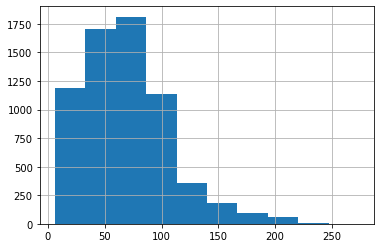

In [ ]:
pd.Series(temp).hist()

## save data

In [ ]:
df_movie_titles_filtered.to_pickle('df_movie_titles_filtered.pkl')
df_train_filtered.to_pickle('df_train_filtered.pkl')
df_val_filtered.to_pickle('df_val_filtered.pkl')
df_test_filtered.to_pickle('df_test_filtered.pkl')

# We're far from finished yet. The rest of the work will be done in Part 3.1.